
=== AUDCAD ===
Level  Buy  Sell  Total
    1  121   116    237
    2   35    32     67
    3   10     9     19
    4    3     3      6
    5    1     3      4
    6    0     1      1
Total  170   164    334


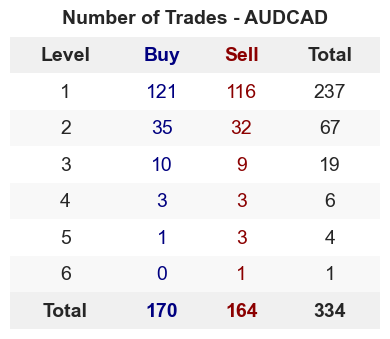

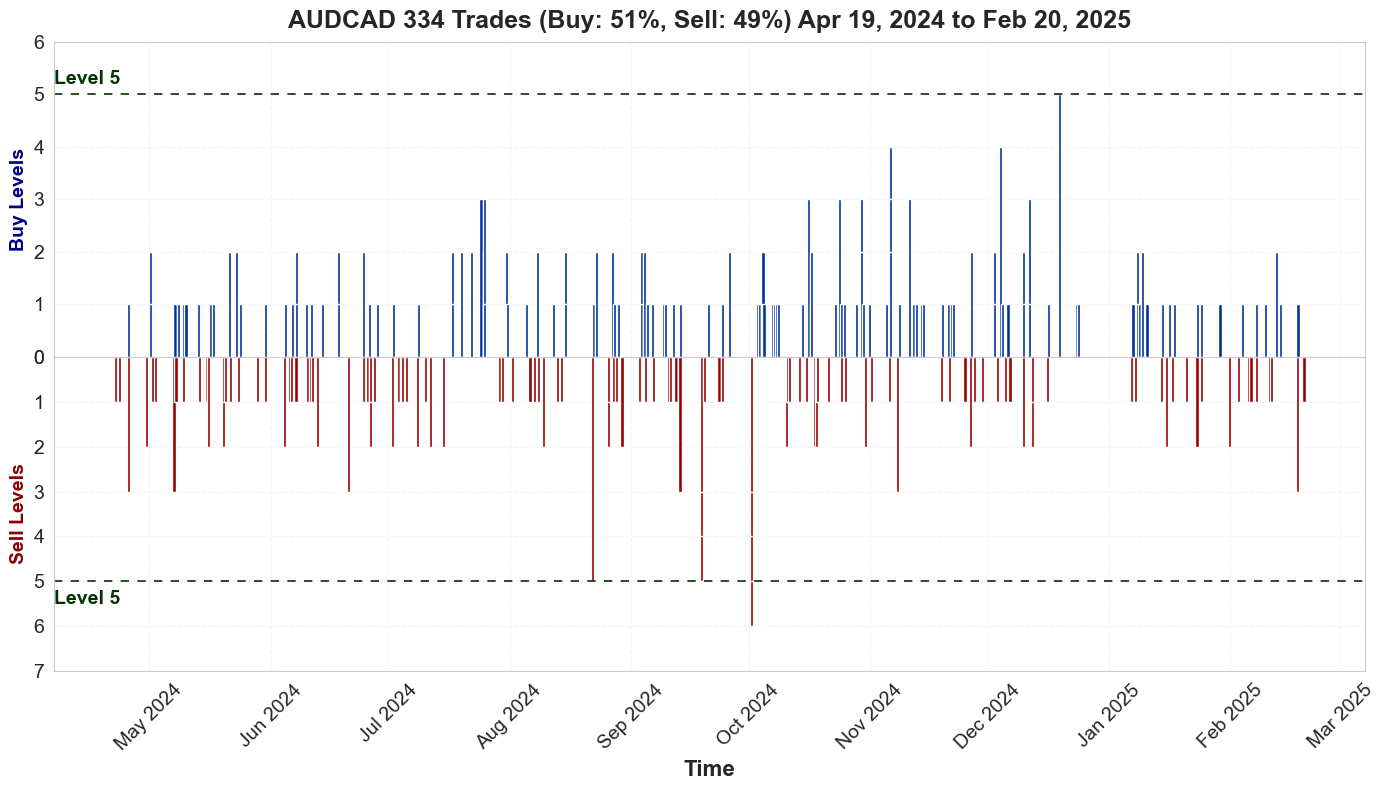


=== AUDCHF ===
Level  Buy  Sell  Total
    1   91    66    157
    2   27    16     43
    3   10     6     16
    4    2     2      4
    5    1     2      3
    6    1     2      3
    7    1     1      2
    8    1     1      2
    9    1     1      2
   10    1     0      1
   11    1     0      1
   12    1     0      1
Total  138    97    235


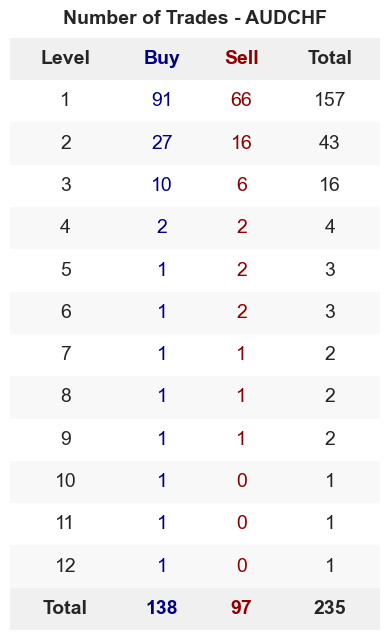

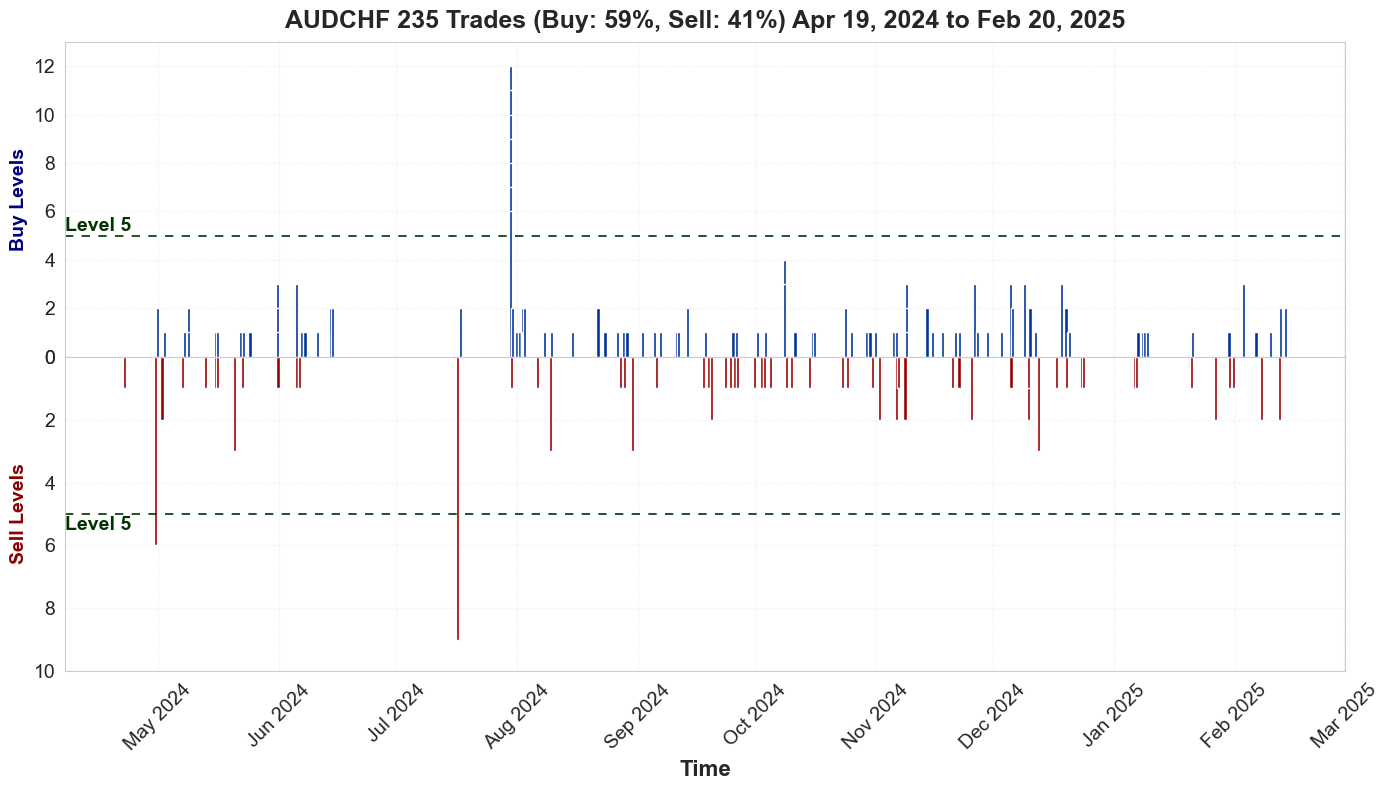


=== AUDNZD ===
Level  Buy  Sell  Total
    1  102   106    208
    2   20    28     48
    3   10     8     18
    4    2     2      4
    5    1     1      2
    6    1     1      2
    7    1     0      1
    8    1     0      1
Total  138   146    284


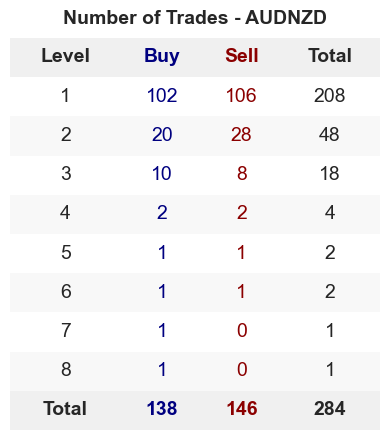

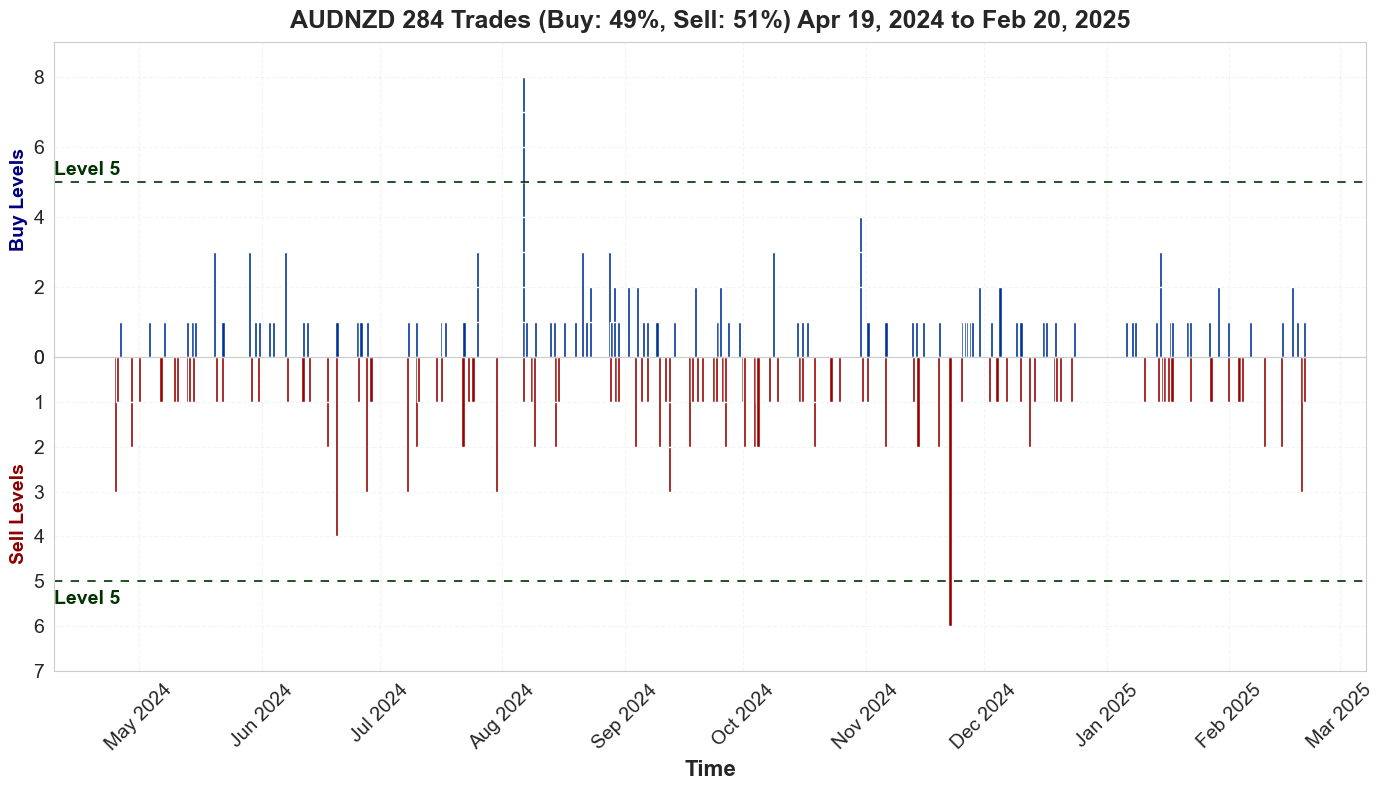


=== AUDUSD ===
Level  Buy  Sell  Total
    1  115   102    217
    2   27    28     55
    3   10     5     15
    4    3     2      5
    5    2     1      3
    6    2     1      3
    7    1     1      2
    8    1     0      1
    9    1     0      1
   10    1     0      1
   11    1     0      1
   12    1     0      1
Total  165   140    305


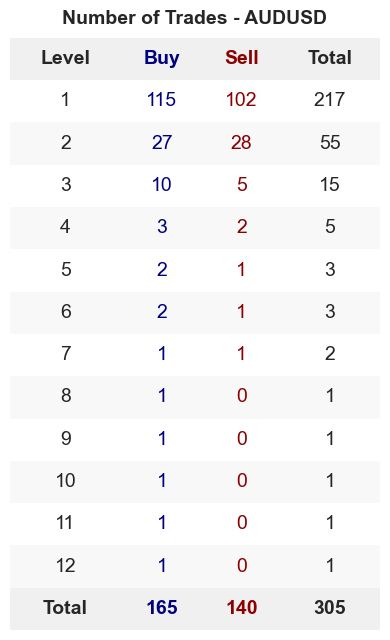

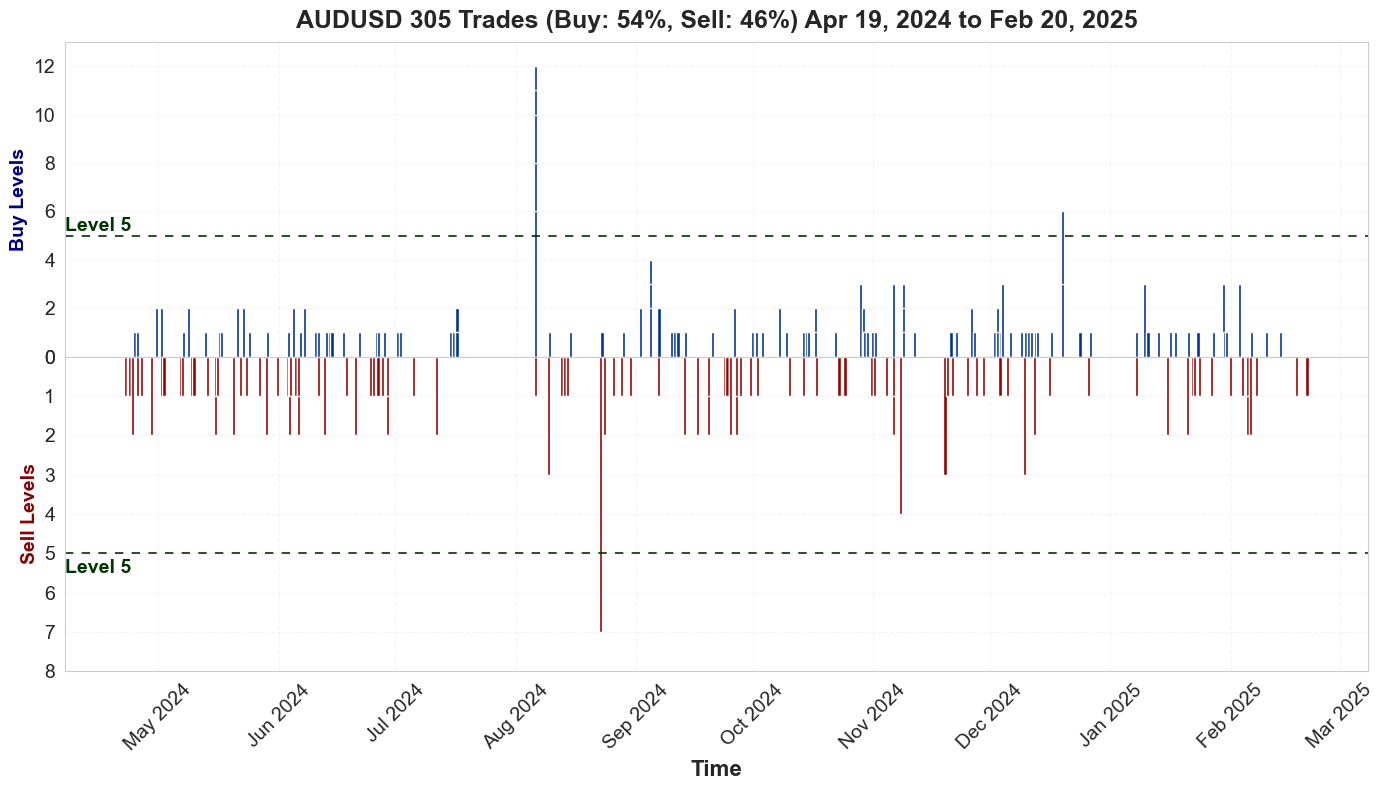


=== CADCHF ===
Level  Buy  Sell  Total
    1   68    70    138
    2   23    20     43
    3    8     6     14
    4    4     2      6
    5    3     1      4
    6    2     1      3
    7    2     1      3
    8    1     0      1
    9    1     0      1
   10    1     0      1
   11    1     0      1
   12    1     0      1
   13    1     0      1
   14    1     0      1
   15    1     0      1
   16    1     0      1
   17    1     0      1
Total  120   101    221


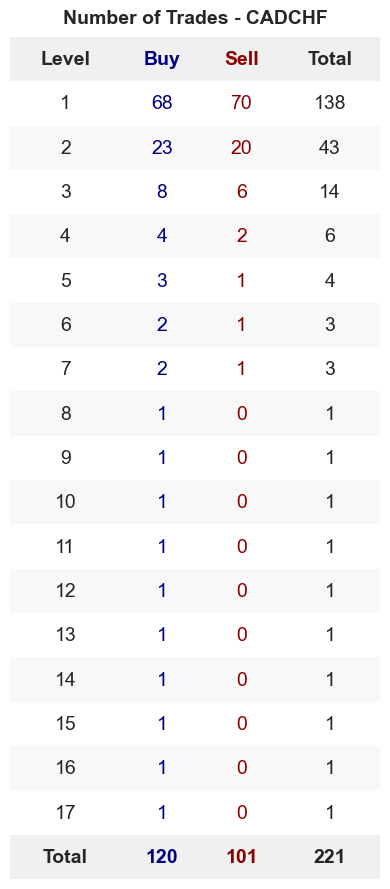

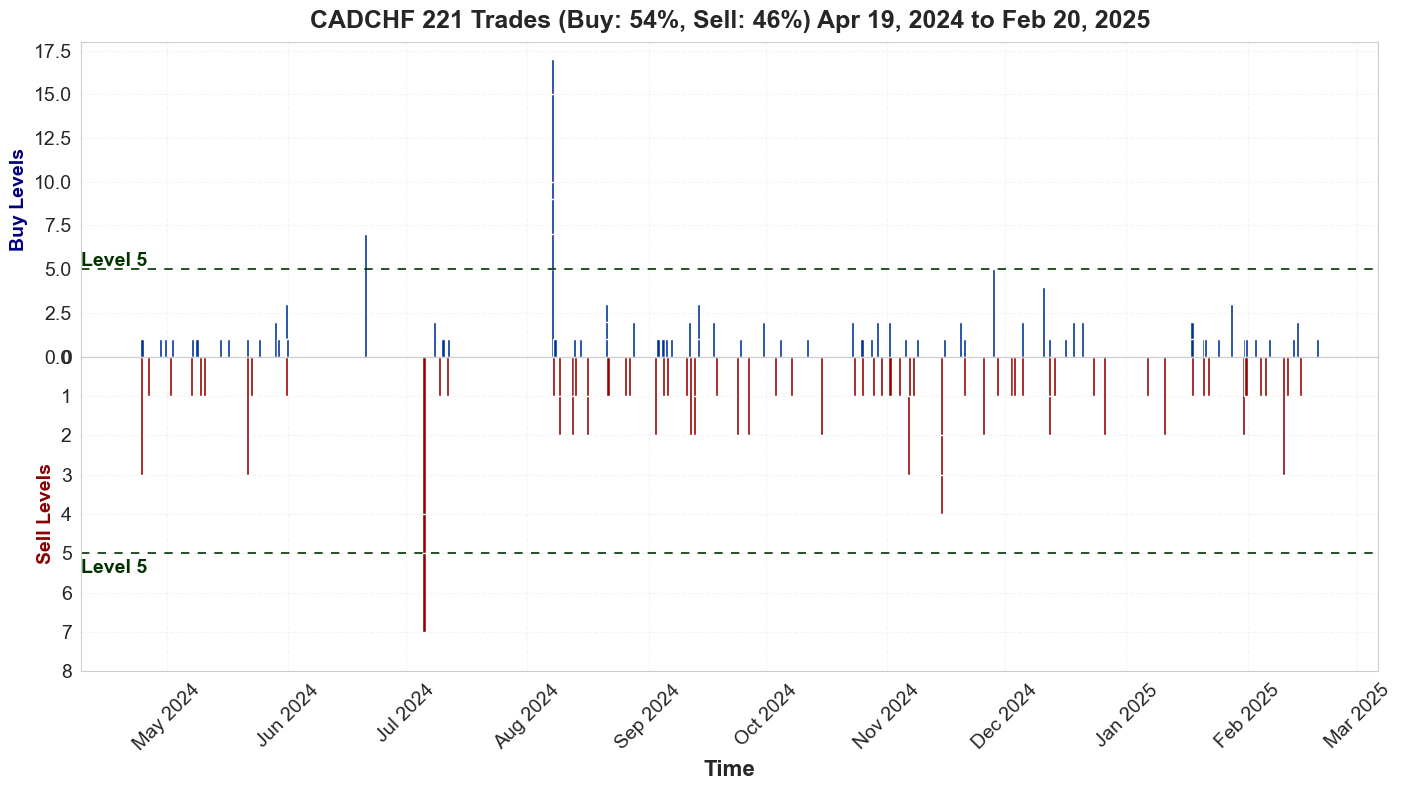


=== EURAUD ===
Level  Buy  Sell  Total
    1  139   147    286
    2   21    22     43
    3    4     5      9
    4    0     3      3
    5    0     1      1
Total  164   178    342


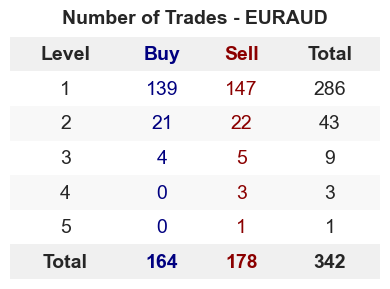

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_style("whitegrid")

def read_and_prepare_data(filename):
    df = pd.read_excel(filename)
    df['Open Time'] = pd.to_datetime(df['Open Time'], format='%Y.%m.%d %H:%M:%S')
    df['Close Time'] = pd.to_datetime(df['Close Time'], format='%Y.%m.%d %H:%M:%S')
    return df

def determine_level(lot_size, pair):
    if pair.lower() == "xauusd": 
        if lot_size <= 0.03:
            return round(lot_size / 0.01)
        else:
            return round((lot_size - 0.3) / 0.1) + 3  
    else:  # Other pairs
        if lot_size <= 0.04:
            return round(lot_size / 0.01)
        else:
            return round((lot_size - 0.4) / 0.1) + 4

def analyze_trades(df):
    results = {}
    for pair in df['Item'].unique():
        pair_df = df[df['Item'] == pair]
        buy_trades = pair_df[pair_df['Type'] == 'buy']
        sell_trades = pair_df[pair_df['Type'] == 'sell']
        
        buy_levels = {}
        sell_levels = {}
        
        for _, row in buy_trades.iterrows():
            level = determine_level(row['Size'], pair)
            buy_levels[level] = buy_levels.get(level, 0) + 1

        for _, row in sell_trades.iterrows():
            level = determine_level(row['Size'], pair)
            sell_levels[level] = sell_levels.get(level, 0) + 1

        levels = sorted(set(buy_levels.keys()).union(sell_levels.keys()))
        df_levels = pd.DataFrame({'Level': levels})
        df_levels['Buy'] = df_levels['Level'].map(buy_levels).fillna(0).astype(int)
        df_levels['Sell'] = df_levels['Level'].map(sell_levels).fillna(0).astype(int)
        df_levels['Total'] = df_levels['Buy'] + df_levels['Sell']
        
        buy_total = df_levels['Buy'].sum()
        sell_total = df_levels['Sell'].sum()
        total_trades = buy_total + sell_total
        
        buy_percent = (buy_total / total_trades) * 100 if total_trades else 0
        sell_percent = (sell_total / total_trades) * 100 if total_trades else 0

        total_row = pd.DataFrame({'Level': ['Total'], 'Buy': [buy_total], 'Sell': [sell_total], 'Total': [total_trades]})
        df_levels = pd.concat([df_levels, total_row], ignore_index=True)
        
        results[pair.upper()] = {
            'df_levels': df_levels,
            'pair_df': pair_df,
            'total_trades': total_trades,
            'buy_percent': buy_percent,
            'sell_percent': sell_percent
        }
    
    return results

def plot_trade_table(df_levels, pair):
    fig, ax = plt.subplots(figsize=(4, len(df_levels) * 0.5))
    ax.axis('off')
    
    table = ax.table(
        cellText=df_levels.values,
        colLabels=df_levels.columns,
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    
    table.auto_set_column_width([0, 1, 2, 3])
    
    for cell in table._cells.values():
        cell.set_edgecolor('none')
    
    for (row, col), cell in table._cells.items():
        cell.set_height(0.04) 
        
        if row == 0:
            cell.set_facecolor('#f0f0f0')
            cell.set_text_props(weight='bold')
        elif row == len(df_levels):
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#f0f0f0')
        else:
            cell.set_facecolor('#f8f8f8' if row % 2 == 0 else '#ffffff')
        
        if col == 1:  
            cell.get_text().set_color('navy')
        elif col == 2:  
            cell.get_text().set_color('darkred')
    
    plt.title(f"Number of Trades - {pair}", 
              fontsize=14, 
              fontweight='bold', 
              pad=10)
    
    plt.tight_layout()
    plt.show()
    
def plot_trade_distribution(results, pair, date_range):
    pair_data = results[pair]
    pair_df = pair_data['pair_df'].sort_values('Close Time')
    buy_trades = pair_df[pair_df['Type'] == 'buy']
    sell_trades = pair_df[pair_df['Type'] == 'sell']

    buy_y = [determine_level(row['Size'], pair) for _, row in buy_trades.iterrows()]
    sell_y = [determine_level(row['Size'], pair) for _, row in sell_trades.iterrows()]

    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'hspace': 0})

    buy_color = (0.0, 0.2, 0.6, 1.0)
    sell_color = (0.6, 0.0, 0.0, 1.0)
    dark_green = (0.0, 0.2, 0.0, 1.0)

    axs[0].bar(buy_trades['Close Time'], buy_y, width=0.8, color=buy_color, alpha=1.0)
    axs[0].set_ylabel("Buy Levels", fontsize=14, color='navy', fontweight='bold')
    axs[0].set_title(f"{pair} {pair_data['total_trades']} Trades (Buy: {pair_data['buy_percent']:.0f}%, Sell: {pair_data['sell_percent']:.0f}%) {date_range}",
                     fontsize=18, fontweight='bold', pad=10)

    axs[1].bar(sell_trades['Close Time'], sell_y, width=0.8, color=sell_color, alpha=1.0)
    axs[1].invert_yaxis()  # Keep sell levels inverted
    axs[1].set_ylabel("Sell Levels", fontsize=14, color='darkred', fontweight='bold')
    axs[1].set_xlabel("Time", fontsize=16, fontweight='bold')

    axs[0].axhline(y=5, color=dark_green, linestyle=(0, (5, 5)), linewidth=1.2)
    axs[1].axhline(y=5, color=dark_green, linestyle=(0, (5, 5)), linewidth=1.2)

    axs[0].text(axs[0].get_xlim()[0], 5.2, "Level 5", fontsize=14, color=dark_green, fontweight="bold")
    axs[1].text(axs[1].get_xlim()[0], 5.5, "Level 5", fontsize=14, color=dark_green, fontweight="bold")

    axs[0].grid(True, linestyle="--", alpha=0.2)
    axs[1].grid(True, linestyle="--", alpha=0.2)

    # Updated x-axis date format to "Mar 2025"
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    axs[0].tick_params(axis='y', labelsize=14)
    axs[1].tick_params(axis='y', labelsize=14)
    axs[1].tick_params(axis='x', labelsize=14)

    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

def generate_trade_report(results, df):
    date_range = f"{df['Open Time'].min().strftime('%b %d, %Y')} to {df['Close Time'].max().strftime('%b %d, %Y')}"
    for pair, data in results.items():
        print(f"\n=== {pair} ===")
        print(data['df_levels'][['Level', 'Buy', 'Sell', 'Total']].to_string(index=False))
        plot_trade_table(data['df_levels'], pair)
        plot_trade_distribution(results, pair, date_range)

df = read_and_prepare_data('shadowhistory.xlsx')
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')
df['Profit'].fillna(0, inplace=True)
results = analyze_trades(df)
generate_trade_report(results, df)
